In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from envs.trading_env import TradingEnv
import ta

# === Step 1: Load raw CSV ===
def load_price_data(path):
    df = pd.read_csv(path)
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    df = df.sort_values('Datetime').reset_index(drop=True)
    return df

# === Step 2: Add indicators ===
def add_technical_features(df):
    df['price_change'] = df['Close'].pct_change()
    df['volatility'] = df['Close'].rolling(window=10).std()
    df['range'] = (df['High'] - df['Low']) / df['Close']

    df['rsi'] = ta.momentum.RSIIndicator(close=df['Close'], window=14).rsi()
    macd = ta.trend.MACD(close=df['Close'])
    df['macd'] = macd.macd_diff()

    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# === Step 3: Setup dataframe ===
window_size = 50
csv_path = "./data/ETH-USD_test_data.csv"

df_raw = load_price_data(csv_path)
df = add_technical_features(df_raw)

usable_rows = len(df)
print(f"✅ Usable rows after indicators: {usable_rows}")

if usable_rows <= window_size:
    raise ValueError(f"❌ Not enough data ({usable_rows}) after indicators for window size {window_size}")

# === Step 4: Create environment ===
feature_cols = ["price_change", "volatility", "range", "rsi", "macd"]
env = TradingEnv(df=df, window_size=window_size, initial_balance=10000, feature_cols=feature_cols)

# === Step 5: Load model ===
model = PPO.load("ppo_trading_bot_parallel.zip", env=env)

# === Step 6: Inference loop with tracking ===
obs, _ = env.reset()
done = False
total_reward = 0

close_prices = []
profits = []
time_steps = []

while not done:
    action, _ = model.predict(obs)
    obs, reward, done, _, _ = env.step(action)
    total_reward += reward

    if env.current_step < len(env.df):  # ✅ Avoid out-of-bounds error
        close_prices.append(env.df.iloc[env.current_step]['Close'])
        profits.append(env.total_profit)
        time_steps.append(env.current_step)

    env.render()


    env.render()


# === Step 7: Final summary ===
print(f"\n🚀 Total Profit: {env.total_profit:.2f}")
print(f"💰 Final Balance: {env.balance:.2f}")


✅ Usable rows after indicators: 16959
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Step: 16959, Balance: 10530.28, Profit: 530.28, Position: 1
Step: 16959, Balance: 10530.28, Profit: 530.28, Position: 1

🚀 Total Profit: 530.28
💰 Final Balance: 10530.28


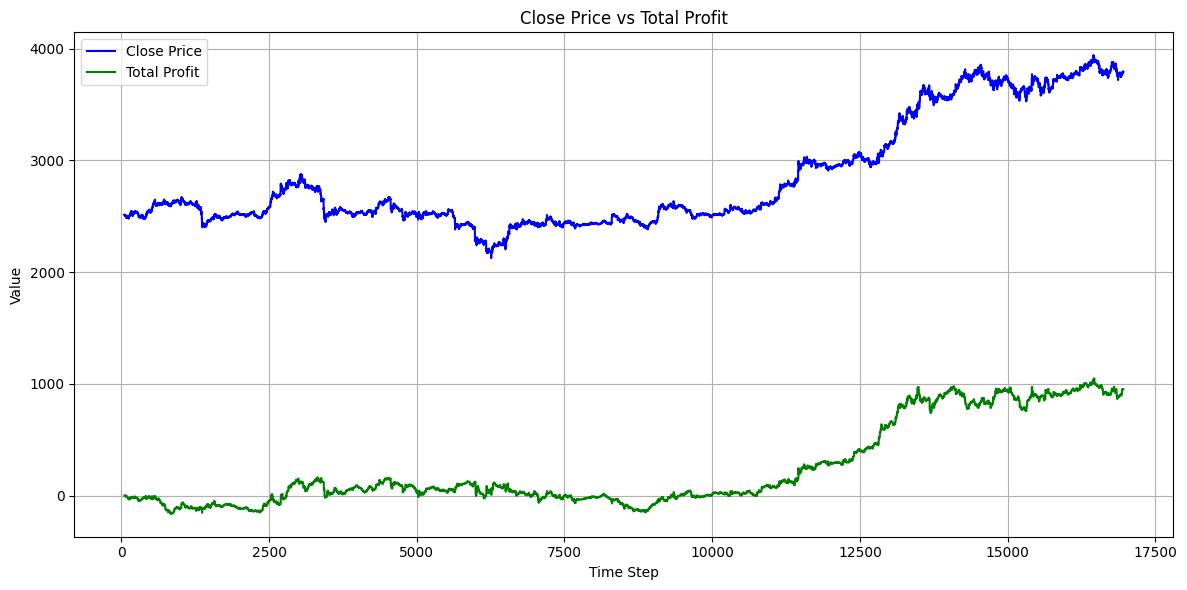

In [15]:
# === Step 8: Plot chart (Close vs Profit) ===
plt.figure(figsize=(12, 6))
plt.plot(time_steps, close_prices, label='Close Price', color='blue')
plt.plot(time_steps, profits, label='Total Profit', color='green')
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("Close Price vs Total Profit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
